# Gender Classification
<p>oleh : Aditya Atallah</p>
<p>NIM  : 2000016097</p>



## Load Dataset

In [1]:
import os, zipfile
import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# unduh dataset
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
dir_zip = "/content/gdrive/MyDrive/Kuliah/Machine Learning/UAS/dataset/gender_predict.zip"
zip_ref =  zipfile.ZipFile(dir_zip, 'r')
zip_ref.extractall('/tmp/gender_predict')
zip_ref.close



<bound method ZipFile.close of <zipfile.ZipFile filename='/content/gdrive/MyDrive/Kuliah/Machine Learning/UAS/dataset/gender_predict.zip' mode='r'>>

In [4]:
train_dir = '/tmp/gender_predict/Training'
val_dir = '/tmp/gender_predict/Validation'

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (160,160)

# pengaturan data dengan berbagai augmentasi
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_data = train_datagen.flow_from_directory(train_dir,
                                              target_size = IMG_SIZE,
                                              batch_size=BATCH_SIZE,
                                              class_mode='binary',
                                               shuffle=True,
                                               seed=42)

val_data = val_datagen.flow_from_directory(val_dir,
                                          target_size=IMG_SIZE,
                                          batch_size=BATCH_SIZE,
                                          class_mode='binary',
                                          seed=42)

Found 47009 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.


In [7]:
# melihat isi direktori
print(os.listdir(train_dir))
print(os.listdir(val_dir))

['female', 'male']
['female', 'male']


## MobileNetV2

In [8]:
# load base model dari pre-trained model
IMG_SHAPE = IMG_SIZE + (3,)
MobileNetV2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
# Bekukan lapisan-lapisan pre-trained
for layer in MobileNetV2.layers:
    layer.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [9]:
print(IMG_SHAPE)

(160, 160, 3)


In [10]:
# Define the model
modelV1 = Sequential([
    MobileNetV2,
    tf.keras.layers.GlobalAveragePooling2D(),
    Dense(1204, activation='relu'),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [11]:
# compile the model
lr = 0.001
modelV1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [13]:
# Callback
# Menerapkan saran Callback EarlyStopping
class EarlyStopping(tf.keras.callbacks.EarlyStopping):
    def __init__(self, patience=3):
        super().__init__(patience=patience)

    def on_epoch_end(self, epoch, logs=None):
        # Hentikan pelatihan jika accuracy mencapai 95%
        if logs['accuracy'] >= 0.95:
            self.model.stop_training = True


In [14]:
# fit the model
initial_epochs = 10
history = modelV1.fit(
    train_data,
    validation_data= val_data,
    epochs=initial_epochs,
    callbacks=[EarlyStopping()]
)

Epoch 1/10
1470/1470 [==============================] - 80s 49ms/step - loss: 0.2660 - accuracy: 0.8921 - val_loss: 0.2151 - val_accuracy: 0.9138
Epoch 2/10
1470/1470 [==============================] - 65s 44ms/step - loss: 0.2159 - accuracy: 0.9153 - val_loss: 0.2203 - val_accuracy: 0.9138
Epoch 3/10
1470/1470 [==============================] - 68s 46ms/step - loss: 0.1996 - accuracy: 0.9212 - val_loss: 0.2143 - val_accuracy: 0.9124
Epoch 4/10
1470/1470 [==============================] - 78s 53ms/step - loss: 0.1863 - accuracy: 0.9285 - val_loss: 0.2021 - val_accuracy: 0.9163
Epoch 5/10
1470/1470 [==============================] - 67s 45ms/step - loss: 0.1722 - accuracy: 0.9341 - val_loss: 0.1960 - val_accuracy: 0.9230
Epoch 6/10
1470/1470 [==============================] - 65s 44ms/step - loss: 0.1604 - accuracy: 0.9383 - val_loss: 0.1990 - val_accuracy: 0.9233
Epoch 7/10
1470/1470 [==============================] - 70s 47ms/step - loss: 0.1483 - accuracy: 0.9422 - val_loss: 0.2047 -

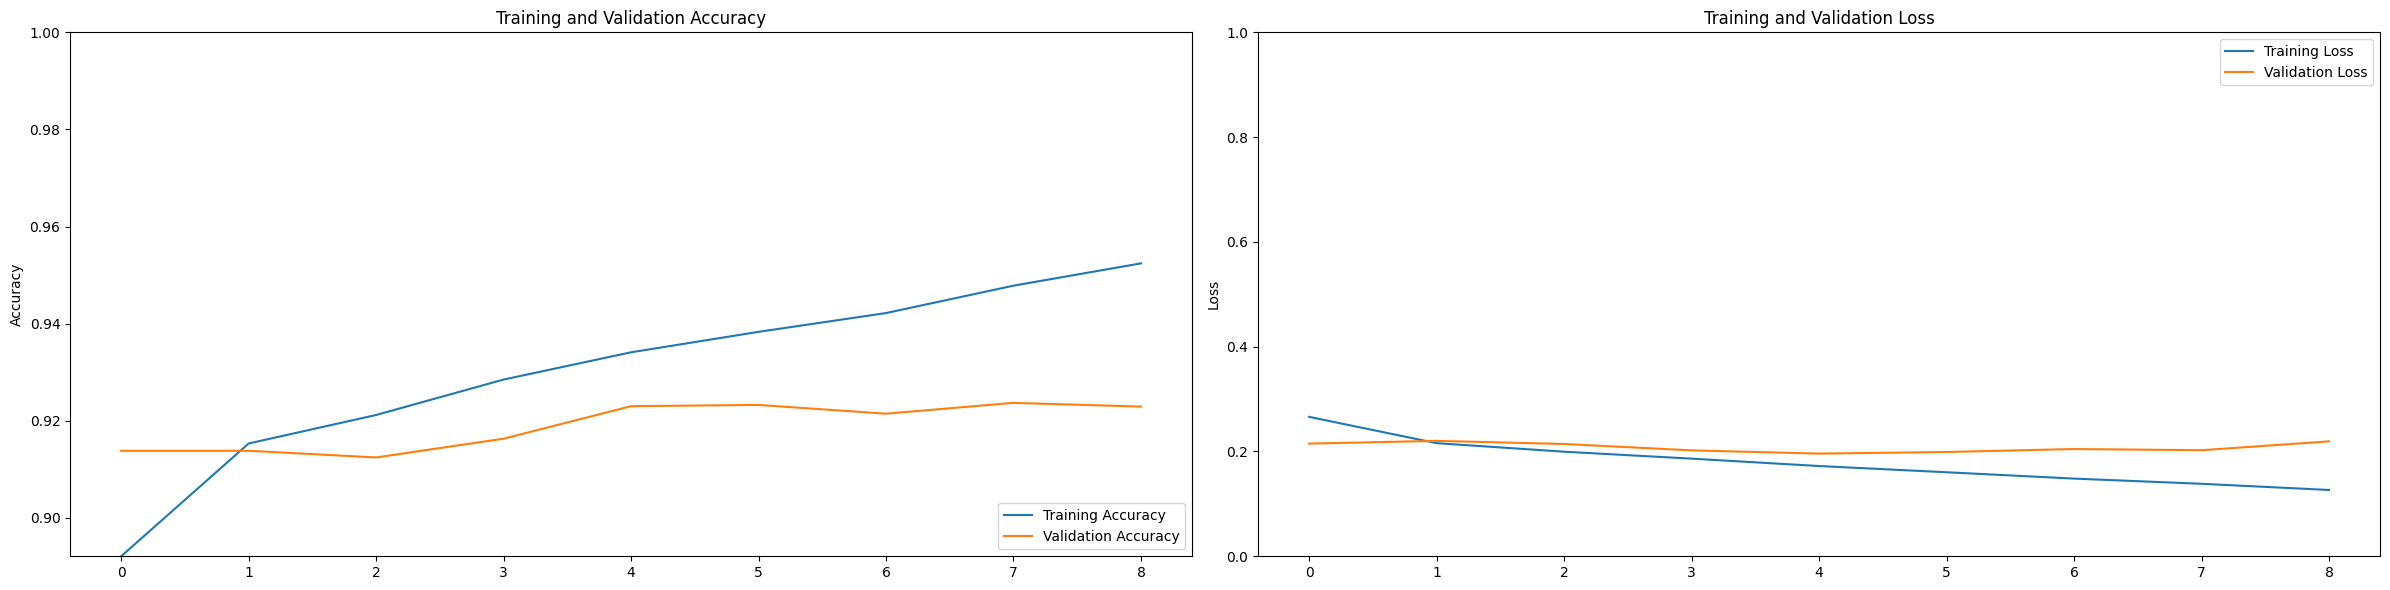

In [27]:
# membuat plot
import matplotlib.pyplot as plt
import seaborn as sns

accur = history.history['accuracy']
val_accur = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accur))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

# Plot untuk subplot pertama (Accuracy)
axs[0].plot(epochs, accur, label='Training Accuracy')
axs[0].plot(epochs, val_accur, label='Validation Accuracy')
axs[0].legend(loc='lower right')
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim([min(min(accur), min(val_accur)), 1])
axs[0].set_title('Training and Validation Accuracy')

# Plot untuk subplot kedua (Loss)
axs[1].plot(epochs, loss, label='Training Loss')
axs[1].plot(epochs, val_loss, label='Validation Loss')
axs[1].legend(loc='upper right')
axs[1].set_ylabel('Loss')
axs[1].set_ylim([0, 1.0])
axs[1].set_title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [15]:
modelV1.save('genderByMobileNet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## VGG19

In [30]:
IMG_SHAPE = IMG_SIZE + (3,)
VGG19 = tf.keras.applications.VGG19(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
for layer in VGG19.layers:
    layer.trainable = False

In [31]:
# Define the model
modelV2 = Sequential([
    VGG19,
    Flatten(),
    Dense(1204, activation='relu'),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [33]:
# compile the model
lr = 0.0001
modelV2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [34]:
# fit the model
initial_epochs = 10
historyV2 = modelV2.fit(
    train_data,
    validation_data= val_data,
    epochs=initial_epochs,
    callbacks=[EarlyStopping()]
)

Epoch 1/10
1470/1470 [==============================] - 173s 114ms/step - loss: 0.2212 - accuracy: 0.9123 - val_loss: 0.1780 - val_accuracy: 0.9307
Epoch 2/10
1470/1470 [==============================] - 165s 113ms/step - loss: 0.1650 - accuracy: 0.9361 - val_loss: 0.1444 - val_accuracy: 0.9433
Epoch 3/10
1470/1470 [==============================] - 164s 112ms/step - loss: 0.1471 - accuracy: 0.9430 - val_loss: 0.1769 - val_accuracy: 0.9302
Epoch 4/10
1470/1470 [==============================] - 165s 112ms/step - loss: 0.1318 - accuracy: 0.9504 - val_loss: 0.1427 - val_accuracy: 0.9470


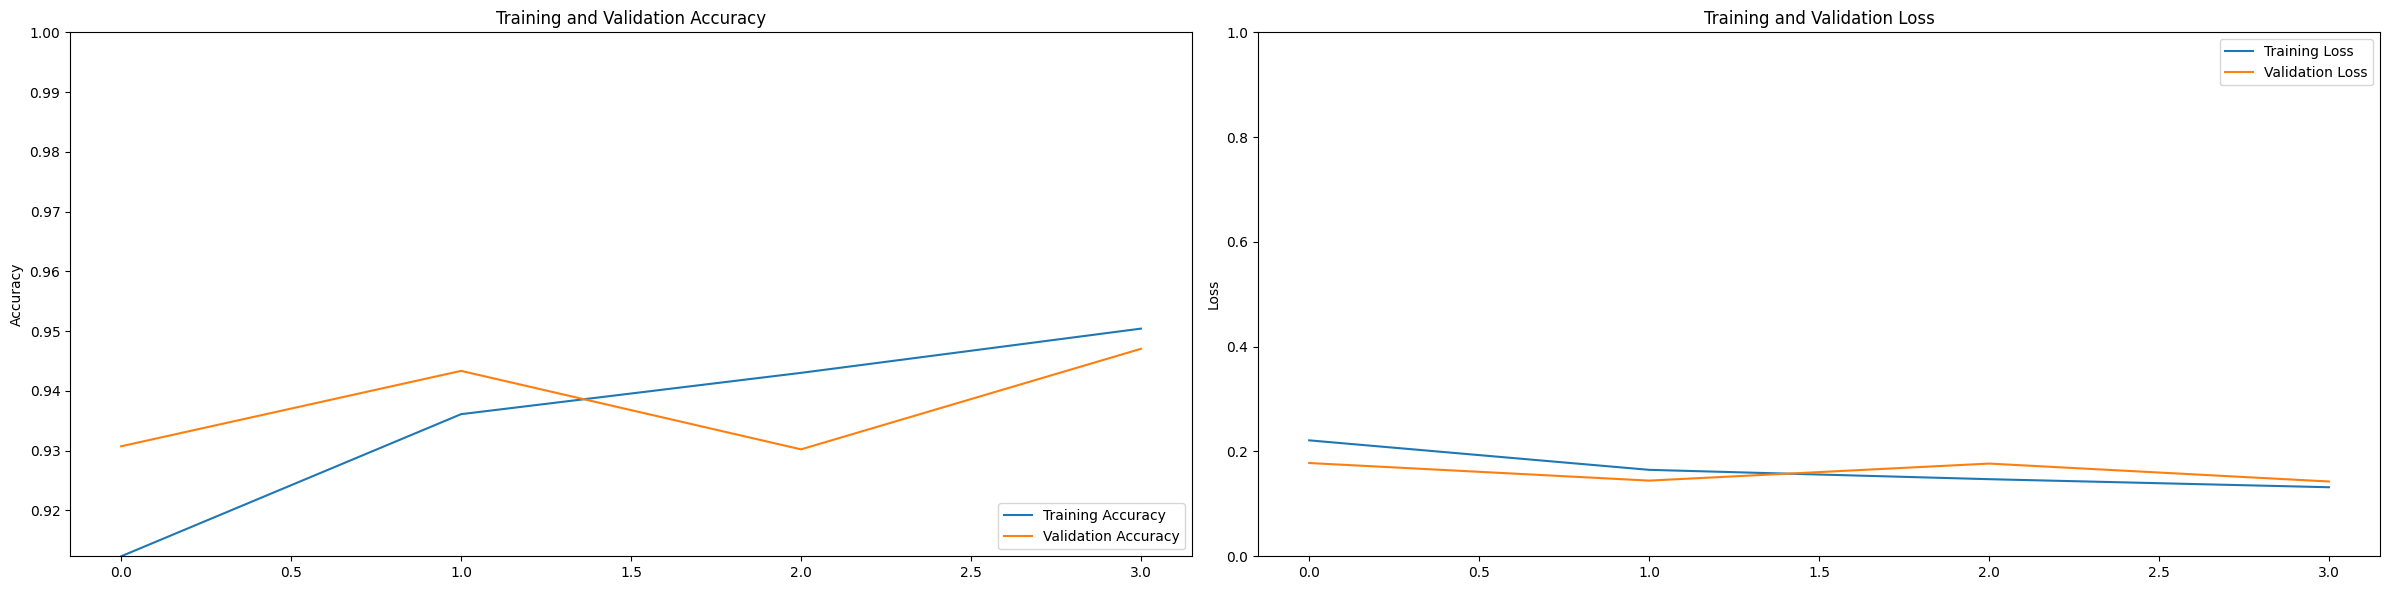

In [35]:
accur = historyV2.history['accuracy']
val_accur = historyV2.history['val_accuracy']
loss = historyV2.history['loss']
val_loss = historyV2.history['val_loss']
epochs = range(len(accur))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

# Plot untuk subplot pertama (Accuracy)
axs[0].plot(epochs, accur, label='Training Accuracy')
axs[0].plot(epochs, val_accur, label='Validation Accuracy')
axs[0].legend(loc='lower right')
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim([min(min(accur), min(val_accur)), 1])
axs[0].set_title('Training and Validation Accuracy')

# Plot untuk subplot kedua (Loss)
axs[1].plot(epochs, loss, label='Training Loss')
axs[1].plot(epochs, val_loss, label='Validation Loss')
axs[1].legend(loc='upper right')
axs[1].set_ylabel('Loss')
axs[1].set_ylim([0, 1.0])
axs[1].set_title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [36]:
modelV2.save('vgg19.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Predict

In [46]:
from tensorflow.keras.preprocessing import image
import numpy as np
from numpy import asarray

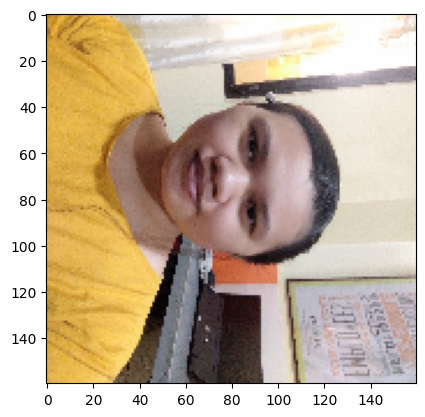

In [55]:
# load image
img = image.load_img('19.jpg', target_size=(160,160))
plt.imshow(img)

In [63]:
# membuat fungsi predict
def predict_gender(img):
  x = image.img_to_array(img)
  x = np.expand_dims(img, axis=0)
  predict = modelV2.predict(x, batch_size=10)
  predict = np.round(predict.item())
  return predict

In [66]:
# melakukan prediksi
yhat = predict_gender(img)
if yhat == 1:
  print('male')
elif yhat == 0:
  print('female')
else:
  print('unrecognized')

1/1 [==============================] - 0s 18ms/step
female
